In [1]:
import pandas as pd
import numpy as np

In [2]:
#the classes ordered by index
classes = [
    '__background__',  # always index 0
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

In [3]:
df_ = pd.read_pickle('./dataset/train_data.pkl')
df_.head()

,image_name,boxes,gt_classes,gt_overlaps,flipped,seg_areas,num_objs,selective_search_boxes
0,2008_000002.jpg,"[[33, 10, 447, 292]]",[20],"(0, 20)\t1.0",False,[117445.0],1,"[[204, 318, 361, 361], [0, 0, 499, 374], [298,..."
1,2008_000003.jpg,"[[45, 10, 499, 332], [61, 189, 82, 242]]","[19, 15]","(0, 19)\t1.0\n (1, 15)\t1.0",False,"[146965.0, 1188.0]",2,"[[0, 0, 281, 332], [162, 51, 499, 133], [39, 0..."
2,2008_000007.jpg,"[[0, 229, 427, 292]]",[4],"(0, 4)\t1.0",False,[27392.0],1,"[[0, 184, 423, 374], [273, 189, 380, 234], [0,..."
3,2008_000008.jpg,"[[52, 86, 470, 419], [157, 43, 288, 166]]","[13, 15]","(0, 13)\t1.0\n (1, 15)\t1.0",False,"[139946.0, 16368.0]",2,"[[259, 147, 399, 441], [124, 198, 272, 276], [..."
4,2008_000009.jpg,"[[216, 160, 293, 220], [464, 166, 499, 217]]","[10, 10]","(0, 10)\t1.0\n (1, 10)\t1.0",False,"[4758.0, 1872.0]",2,"[[211, 309, 420, 374], [0, 271, 499, 374], [0,..."


In [4]:
# prepare training data by transforming coordinates 
# [x1, y1, x2, y2] into [delta_x, delta_y, log(delta_w), log(delta_h)]
def bbox_transform(ex_rois, gt_rois):

    ex_widths = ex_rois[2] - ex_rois[0] + 1.0
    ex_heights = ex_rois[3] - ex_rois[1] + 1.0
    ex_ctr_x = ex_rois[0] + 0.5 * ex_widths
    ex_ctr_y = ex_rois[1] + 0.5 * ex_heights

    gt_widths = gt_rois[2] - gt_rois[0] + 1.0
    gt_heights = gt_rois[3] - gt_rois[1] + 1.0
    gt_ctr_x = gt_rois[0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.array([targets_dx, targets_dy, targets_dw, targets_dh])
    return targets

In [5]:
from PIL import Image
# Here we also resize the images into fixed 500*300 since the size of images are not the same
width = 500
height = 300
boxes_resize = df_['boxes'].copy()
for img in range(len(boxes_resize)):
    imgage = Image.open("./dataset/JPEGImages/" + df_['image_name'][img])
    w = imgage.size[0]
    h = imgage.size[1]
    boxes = boxes_resize[img]

    boxes[:, [0, 2]] = boxes[:, [0, 2]] * (width / w)
    boxes[:, [1, 3]] = boxes[:, [1, 3]] * (height / h)
    boxes_resize[img] = np.array([df_['gt_classes'][img][0]] + bbox_transform(
      np.array([0, 0, width - 1, height - 1]), boxes[0]).tolist())

df_['one_gt'] = boxes_resize
df_.head()

,image_name,boxes,gt_classes,gt_overlaps,flipped,seg_areas,num_objs,selective_search_boxes,one_gt
0,2008_000002.jpg,"[[33, 8, 447, 233]]",[20],"(0, 20)\t1.0",False,[117445.0],1,"[[204, 318, 361, 361], [0, 0, 499, 374], [298,...","[20.0, -0.019, -0.0966666666667, -0.1863295781..."
1,2008_000003.jpg,"[[45, 9, 499, 299], [61, 170, 82, 218]]","[19, 15]","(0, 19)\t1.0\n (1, 15)\t1.0",False,"[146965.0, 1188.0]",2,"[[0, 0, 281, 332], [162, 51, 499, 133], [39, 0...","[19.0, 0.045, 0.015, -0.0943106794712, -0.0304..."
2,2008_000007.jpg,"[[0, 183, 427, 233]]",[4],"(0, 4)\t1.0",False,[27392.0],1,"[[0, 184, 423, 374], [273, 189, 380, 234], [0,...","[4.0, -0.072, 0.195, -0.15548490284, -1.771956..."
3,2008_000008.jpg,"[[52, 58, 470, 284], [157, 29, 288, 112]]","[13, 15]","(0, 13)\t1.0\n (1, 15)\t1.0",False,"[139946.0, 16368.0]",2,"[[259, 147, 399, 441], [124, 198, 272, 276], [...","[13.0, 0.023, 0.0716666666667, -0.1767371785, ..."
4,2008_000009.jpg,"[[216, 128, 293, 176], [464, 132, 499, 173]]","[10, 10]","(0, 10)\t1.0\n (1, 10)\t1.0",False,"[4758.0, 1872.0]",2,"[[211, 309, 420, 374], [0, 271, 499, 374], [0,...","[10.0, 0.01, 0.00833333333333, -1.85789927173,..."


In [6]:
class_count = [300 for i in range(21)]
df_select = df_.copy()
for img in range(len(df_select)):
    if class_count[int(df_select['one_gt'][img][0])] > 0:
        class_count[int(df_select['one_gt'][img][0])] -= 1
    else:
        df_select = df_select.drop(img)

df_select.reset_index(drop=True)
print(class_count)

[300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 71, 0, 0, 0, 0, 68, 24, 0, 0, 0]


In [7]:
df_.to_pickle('./dataset/data_train_one.pkl')

## Hyperparameters

In [8]:
#hyperparameters
batch_size = 16
img_width = 500
img_height = 300
num_classes = 21

## Data loader

In [9]:
import tensorflow as tf
import random
from tensorflow.contrib.data import Dataset, Iterator

/home/rohan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
def _train_valid_split(df, valid_ratio):
    valid_random = np.random.rand(len(df)) < valid_ratio
    return df[~valid_random].reset_index(drop=True), df[valid_random].reset_index(drop=True)

In [11]:
df = pd.read_pickle('./dataset/data_train_one.pkl')
valid_ratio = 0.1
df_train, df_valid = _train_valid_split(df, valid_ratio)

## Define data_generator

In [12]:
def data_generator(image_name):
    # For each image, generate an image array and its name. 
    # As a generator for tf.contrib.data.dataset to use.
    file_path = './dataset/JPEGImages/'
    img_file = tf.read_file(file_path + image_name)

    img = tf.image.decode_image(img_file, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img.set_shape([None, None, 3])
    img = tf.image.resize_images(img, size=[img_width, img_height])

    return img, image_name

## Create tensorflow iterator to process data loading

In [13]:
tf.reset_default_graph()

In [14]:
X_train_image_name = tf.constant(df_train['image_name'].as_matrix())
X_valid_image_name = tf.constant(df_valid['image_name'].as_matrix())

train_dataset = Dataset.from_tensor_slices((X_train_image_name))
valid_dataset = Dataset.from_tensor_slices((X_valid_image_name))

train_dataset = train_dataset.map(
    data_generator, num_threads=4, output_buffer_size=8 * batch_size)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.batch(batch_size)

valid_dataset = valid_dataset.map(
    data_generator, num_threads=4, output_buffer_size=8 * batch_size)
valid_dataset = valid_dataset.shuffle(8 * batch_size)
valid_dataset = valid_dataset.batch(batch_size)

#create TensorFlow Iterator object
iterator = Iterator.from_structure(train_dataset.output_types,
                                   train_dataset.output_shapes)
next_element = iterator.get_next()

#create two initialization ops to switch between the datasets
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(valid_dataset)

Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.
Instructions for updating:
Replace `num_threads=T` with `num_parallel_calls=T`. Replace `output_buffer_size=N` with `ds.prefetch(N)` on the returned dataset.
Instructions for updating:
Replace `num_threads=T` with `num_parallel_calls=T`. Replace `output_buffer_size=N` with `ds.prefetch(N)` on the returned dataset.


## Object detection model

### Define single layers

In [15]:
# convolution
def conv2d(name, input_layer, kernel_size, filters, padding='same', relu=True):
    if relu:
        output = tf.layers.conv2d(
            inputs=input_layer,
            filters=filters,
            kernel_size=kernel_size,
            padding=padding,
            activation=tf.nn.relu,
            name=name)
    else:
        output = tf.layers.conv2d(
            inputs=input_layer,
            filters=filters,
            kernel_size=kernel_size,
            padding=padding,
            name=name)
    return output


# max pooling
def max_pool(name, input_layer, window):
    return tf.layers.max_pooling2d(
        inputs=input_layer, pool_size=[window, window], strides=window)


def norm(name, input_layer):
    return tf.layers.batch_normalization(input_layer)

### Define CNN model

In [16]:
class CNNModel(object):

    def __init__(self, name='cnn'):
        self.name = name
        self.istrain = True
        with tf.variable_scope(self.name):
            self.build_model()

    def build_model(self):
        #input image and roiboxes
        self.input_layer = tf.placeholder(
            dtype=tf.float32, shape=[None, img_width, img_height, 3])
        #input traning ground truth [batch_numer, [label, 4]]
        self.gt_bbox_targets = tf.placeholder(dtype=tf.float32, shape=[None, 5])

        #conv 1
        conv1_1 = conv2d('conv1_1', self.input_layer, [3, 3], 64)
        pool1 = max_pool('pool1', conv1_1, 2)
        norm1 = norm('norm1', pool1)

        conv1_2 = conv2d('conv1_2', norm1, [3, 3], 64)
        pool2 = max_pool('pool2', conv1_2, 2)
        norm2 = norm('norm2', pool2)

        conv2_1 = conv2d('conv2_1', norm2, [3, 3], 64)
        pool2_2 = max_pool('pool2_2', conv2_1, 2)
        norm2_2 = norm('norm2_2', pool2_2)

        conv3_1 = conv2d('conv3_1', norm2_2, [3, 3], 64)
        pool3_1 = max_pool('pool3_1', conv3_1, 2)
        norm3_1 = norm('norm3_1', pool3_1)

        conv3_2 = conv2d('conv3_2', norm3_1, [3, 3], 64)
        pool3_2 = max_pool('pool3_2', conv3_2, 4)
        norm3_2 = norm('norm3_2', pool3_2)

        flatten = tf.reshape(norm3_2, [-1, 1792])

        #dense layers
        dense1 = tf.layers.dense(flatten, 128, activation=tf.nn.relu)
        dropout1 = tf.layers.dropout(dense1, rate=0.4, training=self.istrain)

        dense2 = tf.layers.dense(dropout1, 256, activation=tf.nn.relu)
        dropout2 = tf.layers.dropout(dense2, rate=0.4, training=self.istrain)

        #box and class predication
        ##for object classification
        self.logits_cls = tf.layers.dense(dropout2, num_classes)
        self.out_cls = tf.nn.softmax(self.logits_cls)

        ##for bounding box prediction
        self.logits_reg = tf.layers.dense(dropout2, 4)

        #calculate loss
        gt_cls, gt_reg = tf.split(self.gt_bbox_targets, [1, 4], 1)

        gt_cls_raw = tf.cast(gt_cls, tf.int64)
        gt_cls = tf.reshape(tf.one_hot(gt_cls_raw, num_classes), [-1, num_classes])

        self.loss_cls = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=gt_cls, logits=self.logits_cls))

        self.loss_reg = tf.losses.mean_squared_error(gt_reg, self.logits_reg)

        self.loss = self.loss_cls + 2 * self.loss_reg

        self.lr = tf.placeholder(tf.float32, [])
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)

    def save_model(self, sess, global_step):
        var_list = [v for v in tf.global_variables() if self.name in v.name]
        saver = tf.train.Saver(var_list)
        saver.save(sess, './checkpoint/cnn', global_step)

    def load_model(self, sess):
        var_list = [v for v in tf.global_variables() if self.name in v.name]
        saver = tf.train.Saver(var_list)
        ckpt = tf.train.get_checkpoint_state('./checkpoint/')
        tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)

    def test_mode(self):
        self.istrain = False

    def train_mode(self):
        self.istrain = True

## Training

### load the ground truth

In [17]:
#for each image, get the ground truth target to feed when training
def get_ground_truth(x_indx, dataframe):
    target_batch = []
    for indx in x_indx:
        target_batch.append(dataframe['one_gt'][indx])
    return np.array(target_batch)

### Define training function

In [18]:
def train_model(sess, model, epoch=5):
    for e in range(epoch):
        model.train_mode()
        sess.run(training_init_op)
        losses = []
        while True:
            try:
                x_img, x_img_names = sess.run(next_element)
                x_indx = [
                    df_train.index[df_train['image_name'] == name.decode("utf-8")]
                    .tolist()[0] for name in x_img_names
                ]

                y_gt = get_ground_truth(x_indx, df_train)
                feed_dict = {
                    model.input_layer: x_img,
                    model.gt_bbox_targets: y_gt,
                    model.lr: 0.0001,
                }

                _, loss, step = sess.run(
                    [model.train_op, model.loss, model.global_step],
                    feed_dict=feed_dict)
                losses.append(loss)

            except tf.errors.OutOfRangeError:
                print('%d epoch with training loss %f' % (e, np.mean(losses)))
                break

        model.test_mode()
        sess.run(validation_init_op)
        losses_v = []
        while True:
            try:
                x_img, x_img_names = sess.run(next_element)
                x_indx = [
                    df_valid.index[df_valid['image_name'] == name.decode("utf-8")]
                    .tolist()[0] for name in x_img_names
                ]
                y_gt = get_ground_truth(x_indx, df_valid)

                feed_dict = {
                    model.input_layer: x_img,
                    model.gt_bbox_targets: y_gt,
                }

                loss = sess.run([model.loss], feed_dict=feed_dict)

                losses_v.append(loss)
            except tf.errors.OutOfRangeError:
                print('%d epoch with validation loss %f\n' % (e, np.mean(losses_v)))
                break
    return step

### Train

In [19]:
model = CNNModel()
sess = tf.Session()
with tf.device('/device:GPU:0'):
    sess.run(tf.global_variables_initializer())
    step = train_model(sess, model)
model.save_model(sess, step)

0 epoch with training loss 3.564889
0 epoch with validation loss 3.509426

1 epoch with training loss 3.446880
1 epoch with validation loss 3.452805

2 epoch with training loss 3.376414
2 epoch with validation loss 3.430021

3 epoch with training loss 3.290124
3 epoch with validation loss 3.305807

4 epoch with training loss 3.213516
4 epoch with validation loss 3.244525



## Testing and run evaluation function

In [20]:
df_test = pd.read_pickle('./dataset/test_data.pkl')

In [21]:
tf.reset_default_graph()
#read testing data
X_test_image_name = tf.constant(df_test['image_name'].as_matrix())
test_dataset = Dataset.from_tensor_slices((X_test_image_name))

test_dataset = test_dataset.map(
    data_generator, num_threads=4, output_buffer_size=20)
test_dataset = test_dataset.batch(1)

iterator = Iterator.from_structure(test_dataset.output_types,
                                   test_dataset.output_shapes)
next_element = iterator.get_next()
testing_init_op = iterator.make_initializer(test_dataset)

In [22]:
#load model
model = CNNModel()

result_cls, result_reg = [], []
with tf.Session() as sess:
    model.load_model(sess)
    model.test_mode()
    with tf.device('/gpu:0'):
        sess.run(testing_init_op)
        while True:
            try:
                x_img, x_img_name = sess.run(next_element)

                feed_dict = {model.input_layer: x_img}

                logits_cls, logits_reg = sess.run(
                    [model.out_cls, model.logits_reg], feed_dict=feed_dict)

                result_cls.append(logits_cls)
                result_reg.append(logits_reg)
            except tf.errors.OutOfRangeError:
                break

INFO:tensorflow:Loading model ./checkpoint/cnn-2915.
INFO:tensorflow:Restoring parameters from ./checkpoint/cnn-2915


## Function from regression output to bounding box

In [23]:
def reg_to_bbox(reg, box):
    bbox_width = box[2] - box[0] + 1.0
    bbox_height = box[3] - box[1] + 1.0
    bbox_ctr_x = box[0] + 0.5 * bbox_width
    bbox_ctr_y = box[1] + 0.5 * bbox_height

    out_ctr_x = reg[0] * bbox_width + bbox_ctr_x
    out_ctr_y = reg[1] * bbox_height + bbox_ctr_y

    out_width = bbox_width * 10**reg[2]
    out_height = bbox_height * 10**reg[3]

    return np.array([
        max(0, out_ctr_x - 0.5 * out_width),
        max(0, out_ctr_y - 0.5 * out_height),
        min(img_width, out_ctr_x + 0.5 * out_width),
        min(img_height, out_ctr_y + 0.5 * out_height)
    ])

### Output bounding boxes

In [24]:
num_test_img = df_test.shape[0]

bbox_preds = []
bbox_cls = []
for img in range(num_test_img):
    bbox_pred = []
    bbox_c = []
    bbox_pred.append(
      reg_to_bbox(result_reg[img][0], np.array([0, 0, img_width, img_height])))
    bbox_c.append(np.argmax(result_cls[img]))

    bbox_cls.append(np.array(bbox_c))
    bbox_preds.append(np.array(bbox_pred))

In [25]:
for img in range(num_test_img):
    imgage = Image.open("./dataset/JPEGImages/" + df_test['image_name'][img])
    w = imgage.size[0]
    h = imgage.size[1]
    boxes = bbox_preds[img]

    boxes[:, [0, 2]] = boxes[:, [0, 2]] * (w / img_width)
    boxes[:, [1, 3]] = boxes[:, [1, 3]] * (h / img_height)
    bbox_preds[img] = boxes

### Run evaluation function and get csv file

In [26]:
import sys
#please ad ./evaluate file into your system path
sys.path.insert(0, './evaluate')

In [27]:
from evaluate import *
evaluate(bbox_preds, bbox_cls)

## Visualization

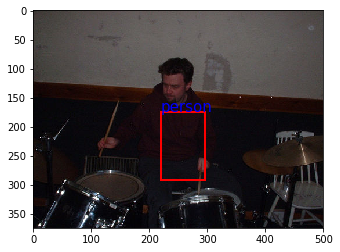

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
show = 21
im = np.array(
    Image.open("./dataset/JPEGImages/" + df_test['image_name'][show]),
    dtype=np.uint8)

# Create figure and axes
fig, ax = plt.subplots(1)

# Show the image
ax.imshow(im)

# Create a Rectangle patch
x1, y1, x2, y2 = bbox_preds[show][0].astype(int)

rect = patches.Rectangle(
    (x1, y1),
    x2 - x1,
    y2 - y1,
    linewidth=2,
    edgecolor='r',
    facecolor='none',
    label=classes[int(bbox_cls[show])])

# Add the bounding box to the Axes
ax.add_patch(rect)
plt.text(x1, y1, classes[int(bbox_cls[show])], color='blue', fontsize=15)

plt.show()